# Quick start

This notebook shows how to use `osculari` to conduct psychophysics on deep neural networks. We learn:
* Extract features from an intermediate layer of the `ResNet` network.
* To train a two-alternative-forced-choice (2AFC) linear probe on the frozen pretrained network.
* Evaluate the network's sensitivity using the staircase procedure.

In this example, we are interested in evaluating the [contrast sensitivity function (CSF) of deep 
neural networks](https://doi.org/10.1016/j.neunet.2023.04.032).

[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/osculari/blob/main/docs/source/notebooks/quick_start.ipynb)

If you are running this notebook on Google Colab, install osculari by uncommenting and executing
the cell below.

In [ ]:
# !pip install osculari

In [1]:
# importing required packages
import osculari

import numpy as np
from matplotlib import pyplot as plt
import torch

## Prtrained features

Let's create a linear classifier on top of the extracted features from a pretrained network to 
perform a binary classification task (i.e., 2AFC – two-alternative-force-choice). This is easily 
achieved by calling the `cat_paradigm_2afc` from the `osculari.models` module.

In [2]:
architecture = 'resnet50'        # networks' architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                 # the readout layer
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
}

pooling = None                   # whether reduce the spatial resolution of features by pooling
classifier_kwargs  = {           # parameters for linear probe layer
    'pooling': pooling           
}
net_2afc = osculari.models.cat_paradigm_2afc(**readout_kwargs, **classifier_kwargs)

## Dataset

The `osculari.datasets` module provides datasets that are generated randomly on the fly with
flexible properties that can be dynamically changed based on the experiment of interest.
In this example, we use the `ShapeAppearanceDataset` class to create two images with different
levels of contrast. To do so, we pass the `contrast_fun` as the merging function that takes
care of experiment-dependent appearance settings. Other experiments can use the same template
and only implement a new merging function.

In [4]:
def contrast_fun(fgs, bgs):
    """
    Merging the foreground (fgs) and background (bgs) images. The ground truth is the image with
    higher level of contrast.
    """
    num_imgs = len(fgs)
    contrast0, contrast1 = np.random.uniform(0.04, 1, 2)
    gt = 0 if contrast0 > contrast1 else 1
    contrasts = [contrast0, contrast1]
    colour = [np.random.randint(0, 256) for _ in range(3)]
    imgs = []
    for i in range(num_imgs):
        img = bgs[i].copy()
        for c in range(3):
            chn = img[..., c]
            chn[fgs[i]] = colour[c] / 255
            img[..., c] = chn
        img = (1 - contrasts[i]) / 2.0 + np.multiply(img, contrasts[i])
        imgs.append(img)
    return imgs, gt

In [8]:
num_samples = 1000               # the number of random samples generated in the dataset
num_imgs = net_2afc.input_nodes  # the number of images in each sample
background = 128                 # the background type
dataset = osculari.datasets.geometrical_shapes.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, background, contrast_fun,
    unique_bg=True, transform=net_2afc.preprocess_transform()
)

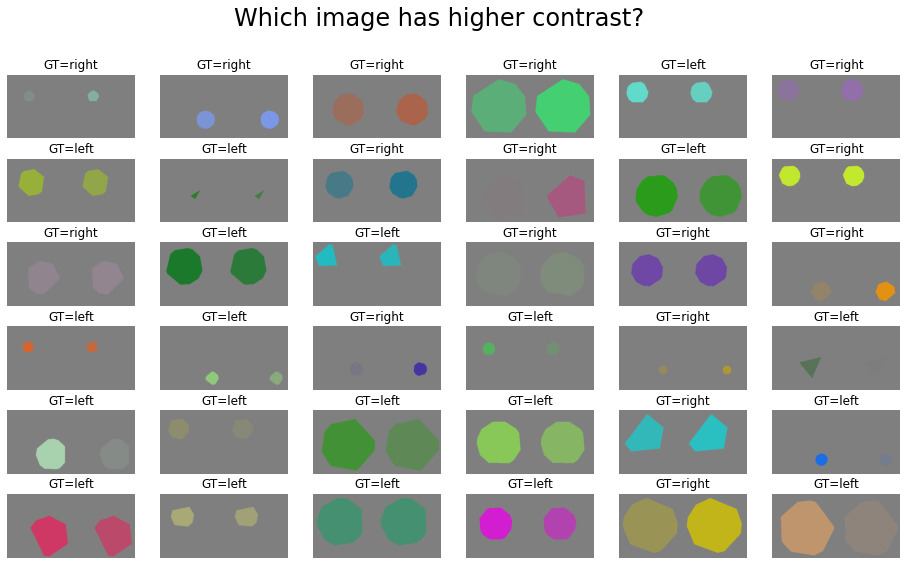

In [23]:
# visualising a few samples from our dataset
fig = plt.figure(figsize=(16, 9))
fig.suptitle('Which image has higher contrast?', fontsize=24)
for i in range(36):
    # one sample from dataset
    sample = dataset.__getitem__(i)
    ax = fig.add_subplot(6, 6, i+1)
    # concatenating  the images for visualisation
    disp_img = np.concatenate([sample[0], sample[1]], axis=2)
    # convering torch images to numpy
    disp_img = disp_img.transpose(1, 2, 0)
    disp_img = disp_img * net_2afc.normalise_mean_std[1] + net_2afc.normalise_mean_std[0]
    ax.imshow(disp_img)
    ax.set_title('GT=%s' % ('left' if sample[2] == 0 else 'right'))
    ax.axis('off')

## Linear Probe

The `osculari.paradigms` module implements a set of psychophysical paradigms. The `train_linear_probe`
function trains the network on a dataset following the paradigm passed to the function.

In [24]:
# experiment-dependent function to process an epoch of data
epoch_fun = osculari.paradigms.forced_choice.epoch_loop
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    net_2afc, dataset, epoch_fun, './osculari_test/'
)

[000] accuracy=0.541 loss=376105.870
[001] accuracy=0.678 loss=258967.679
[002] accuracy=0.671 loss=253609.120
[003] accuracy=0.718 loss=220654.829
[004] accuracy=0.693 loss=279458.878
[005] accuracy=0.849 loss=61961.632
[006] accuracy=0.861 loss=50463.149
[007] accuracy=0.887 loss=36798.491
[008] accuracy=0.863 loss=42982.692
[009] accuracy=0.896 loss=40387.377


## Psychophysical experiment

The `osculari.paradigms` module also implements a set of psychophysical experiments similar to the
experiments conducted with human participants. In this example, we use the `staircase` function
to gradually measure the network's sensitivity.

In [29]:
class ContrastGratingsDataset(osculari.datasets.gratings.GratingsDataset):
    """Returning two gratings, one uniform gray and another with sinusoidal gratings."""

    def __init__(self, contrasts, img_size, spatial_frequency, **kwargs):
        super(ContrastGratingsDataset, self).__init__(
            img_size=img_size, spatial_frequencies=[spatial_frequency], **kwargs
        )
        self.contrasts = contrasts


    def __getitem__(self, idx):
        stimuli0 = self.make_grating(idx, self.contrasts[0])
        stimuli1 = self.make_grating(idx, self.contrasts[1])
        if self.transform:
            stimuli0 = self.transform(stimuli0).float()
            stimuli1 = self.transform(stimuli1).float()
        gt = np.argmax(self.contrasts)
        return stimuli0, stimuli1, gt

In [30]:
def dataset_fun(contrast_level, spatial_frequency, transform, img_size):
    dataset_kwargs = {
        'img_size': img_size,
        'spatial_frequency': spatial_frequency,
        'gaussian_sigma': None,
        'transform': transform
    }
    test_dataset = torch.utils.data.ConcatDataset([
        ContrastGratingsDataset([contrast_level, 0], **dataset_kwargs),
        ContrastGratingsDataset([0, contrast_level], **dataset_kwargs)
    ])
    return test_dataset, test_dataset.__len__(), 0.749

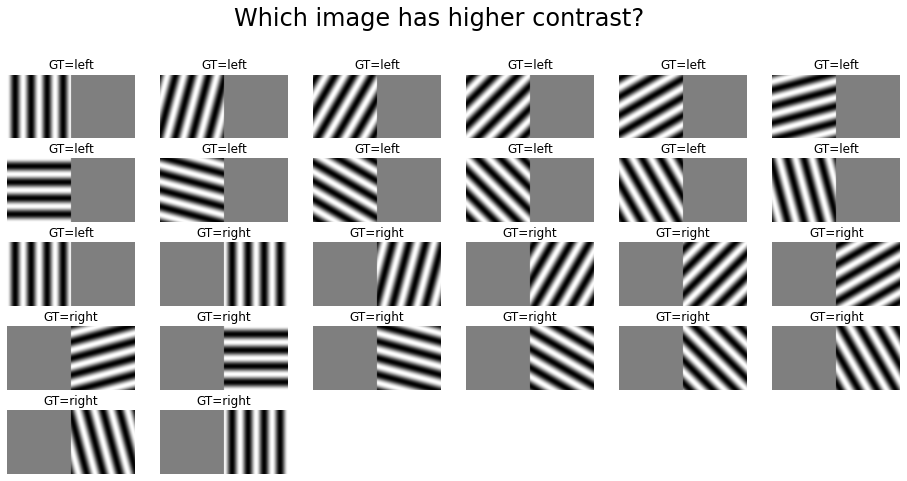

In [52]:
# visualising all samples for test set with spatial frequency equals 4
fig = plt.figure(figsize=(16, 9))
fig.suptitle('Which image has higher contrast?', fontsize=24)
test_dataset, _, _ = dataset_fun(1, 4, net_2afc.preprocess_transform(), img_size)
for i in range(test_dataset.__len__()):
    # one sample from dataset
    sample = test_dataset.__getitem__(i)
    ax = fig.add_subplot(6, 6, i+1)
    # concatenating  the images for visualisation
    disp_img = np.concatenate([sample[0], sample[1]], axis=2)
    # convering torch images to numpy
    disp_img = disp_img.transpose(1, 2, 0)
    disp_img = disp_img * net_2afc.normalise_mean_std[1] + net_2afc.normalise_mean_std[0]
    ax.imshow(np.maximum(np.minimum(disp_img, 1), 0))
    ax.set_title('GT=%s' % ('left' if sample[2] == 0 else 'right'))
    ax.axis('off')

In [31]:
# experiment-dependent function to test an epoch of data
test_epoch_fun = osculari.paradigms.forced_choice.test_dataset

sfs = [i for i in range(1, img_size // 2 + 1) if img_size % i == 0]
csf = []
# looping through all spatial frequencies
for sf in sfs:
    db_fun = lambda contrast: dataset_fun(contrast, sf, net_2afc.preprocess_transform(), img_size)
    # calling the staircase procedure for current spatial frequency
    test_log = osculari.paradigms.staircase(net_2afc, test_epoch_fun, db_fun, low_val=0, high_val=1)
    # the first column of the last row in test_log is the contrast at threshold
    csf.append(test_log[-1, 0])

We have obtained the CSF of `block0` of `ResNet50` which can be directly compared to human data
to investigate whether they are similar or not.

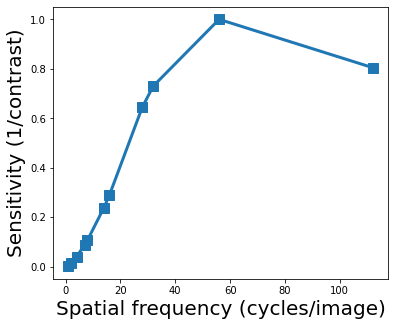

In [47]:
# let's visualise the obtained CSF
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1,)
sensitivity = 1 / np.array(csf)
sensitivity /= sensitivity.max()
ax.plot(np.array(sfs), sensitivity, '-s', markersize=10, linewidth=3)
ax.set_xlabel('Spatial frequency (cycles/image)', fontsize=20)
ax.set_ylabel('Sensitivity (1/contrast)', fontsize=20)
plt.show()